In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# Load the dataset
darwin = 'data.csv'  # Update this path
darwin = pd.read_csv(darwin)

# Peek at the first few rows of the dataset
darwin.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [3]:
darwin['class'] = darwin['class'].replace({'P': 0, 'H': 1})
darwin.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,0
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,0
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,0
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,0
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,0


In [4]:
# Convert object columns to categorical codes if they are categorical
for col in darwin.columns:
    if darwin[col].dtype == 'object':
        darwin[col] = darwin[col].astype('category').cat.codes

In [5]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'darwin' is your DataFrame and 'class' is the label column
features = darwin.drop(['class'], axis=1).values
labels = darwin['class'].values

# Split data into training and the rest (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)  # 70% for training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splits 15% each for val and test

# Convert and reshape the data
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Reshape for sequence dimension
X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)

y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # You can adjust batch size according to your system's capabilities
dl_train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
dl_val = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)
dl_test = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

# Print to verify shapes
print("Training data shape:", X_train_tensor.shape)
print("Validation data shape:", X_val_tensor.shape)
print("Testing data shape:", X_test_tensor.shape)


Training data shape: torch.Size([121, 1, 451])
Validation data shape: torch.Size([26, 1, 451])
Testing data shape: torch.Size([27, 1, 451])


In [21]:
# # Reshape the input data to include a sequence length of 1
# features_tensor = features_tensor.unsqueeze(1)  # Adds a sequence length of 1
# print("Reshaped input features shape:", features_tensor.shape)


Reshaped input features shape: torch.Size([174, 1, 451])


# GRU MODEL

In [10]:
import torch
from torch import nn, optim

class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device  # Get the device from the input tensor
        hidden = self.init_hidden(batch_size, device)
        r_out, hidden = self.gru(x, hidden)
        r_out = r_out[:, -1, :]  # Only take the output from the final timestep
        output = self.fc1(r_out)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.sigmoid(output)
        return output

    def init_hidden(self, batch_size, device):
        # Initialize hidden state with zeros and ensure it's on the correct device
        return torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

# Initialize the model, loss function, and optimizer
model = GRU(input_size=451, output_size=1, hidden_dim=128, n_layers=2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
# #Ensure Input Shape

# # Assuming features and labels have been loaded and preprocessed
# # Check and reshape the features to fit the expected input shape for the GRU
# import numpy as np

# # Assuming features are already loaded as NumPy arrays and need reshaping
# # Example reshaping if necessary (make sure your data fits this structure)
# # features = features.reshape(-1, 10, input_size)  # Adjust '10' based on your sequence length

# # Conversion to tensor and loader setup
# features_tensor = torch.tensor(features, dtype=torch.float32)
# labels_tensor = torch.tensor(labels, dtype=torch.float32)

# # Create TensorDataset and DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# dataset = TensorDataset(features_tensor, labels_tensor)
# train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


# Configure the Optimizer and Loss Function


In [16]:
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


# Training Loop

In [11]:
# # Assuming this is your DataLoader setup
# batch_size = 32
# dl_train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
# dl_val = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)
# dl_test = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

# Define the training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        total_val_loss = 0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                total_val_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Execute the training process using the correct DataLoader names
train_model(model, dl_train, dl_val, criterion, optimizer, num_epochs=40)


Epoch 1/40, Train Loss: 0.6921, Val Loss: 0.6957
Epoch 2/40, Train Loss: 0.6709, Val Loss: 0.6878
Epoch 3/40, Train Loss: 0.6539, Val Loss: 0.6832
Epoch 4/40, Train Loss: 0.6280, Val Loss: 0.6620
Epoch 5/40, Train Loss: 0.5978, Val Loss: 0.6433
Epoch 6/40, Train Loss: 0.5589, Val Loss: 0.6336
Epoch 7/40, Train Loss: 0.5263, Val Loss: 0.6193
Epoch 8/40, Train Loss: 0.4775, Val Loss: 0.5606
Epoch 9/40, Train Loss: 0.4180, Val Loss: 0.5759
Epoch 10/40, Train Loss: 0.3758, Val Loss: 0.5757
Epoch 11/40, Train Loss: 0.3396, Val Loss: 0.5613
Epoch 12/40, Train Loss: 0.3018, Val Loss: 0.5467
Epoch 13/40, Train Loss: 0.2773, Val Loss: 0.6400
Epoch 14/40, Train Loss: 0.2343, Val Loss: 0.5757
Epoch 15/40, Train Loss: 0.2092, Val Loss: 0.5997
Epoch 16/40, Train Loss: 0.1839, Val Loss: 0.6690
Epoch 17/40, Train Loss: 0.1615, Val Loss: 0.6340
Epoch 18/40, Train Loss: 0.1423, Val Loss: 0.6452
Epoch 19/40, Train Loss: 0.1197, Val Loss: 0.7413
Epoch 20/40, Train Loss: 0.1196, Val Loss: 0.7658
Epoch 21/

In [12]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40):
    train_losses = []  # To store training loss per epoch
    val_losses = []  # To store validation loss per epoch
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        total_val_loss = 0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                total_val_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses


In [13]:
train_losses, val_losses = train_model(model, dl_train, dl_val, criterion, optimizer, num_epochs=40)


Epoch 1/40, Train Loss: 0.0082, Val Loss: 1.2659
Epoch 2/40, Train Loss: 0.0078, Val Loss: 1.2178
Epoch 3/40, Train Loss: 0.0070, Val Loss: 1.2849
Epoch 4/40, Train Loss: 0.0063, Val Loss: 1.3029
Epoch 5/40, Train Loss: 0.0060, Val Loss: 1.2983
Epoch 6/40, Train Loss: 0.0056, Val Loss: 1.2794
Epoch 7/40, Train Loss: 0.0053, Val Loss: 1.3270
Epoch 8/40, Train Loss: 0.0049, Val Loss: 1.3636
Epoch 9/40, Train Loss: 0.0047, Val Loss: 1.3987
Epoch 10/40, Train Loss: 0.0045, Val Loss: 1.3909
Epoch 11/40, Train Loss: 0.0041, Val Loss: 1.3761
Epoch 12/40, Train Loss: 0.0041, Val Loss: 1.3405
Epoch 13/40, Train Loss: 0.0039, Val Loss: 1.4221
Epoch 14/40, Train Loss: 0.0037, Val Loss: 1.4652
Epoch 15/40, Train Loss: 0.0035, Val Loss: 1.4488
Epoch 16/40, Train Loss: 0.0033, Val Loss: 1.4369
Epoch 17/40, Train Loss: 0.0031, Val Loss: 1.4580
Epoch 18/40, Train Loss: 0.0030, Val Loss: 1.4698
Epoch 19/40, Train Loss: 0.0028, Val Loss: 1.4970
Epoch 20/40, Train Loss: 0.0028, Val Loss: 1.4897
Epoch 21/

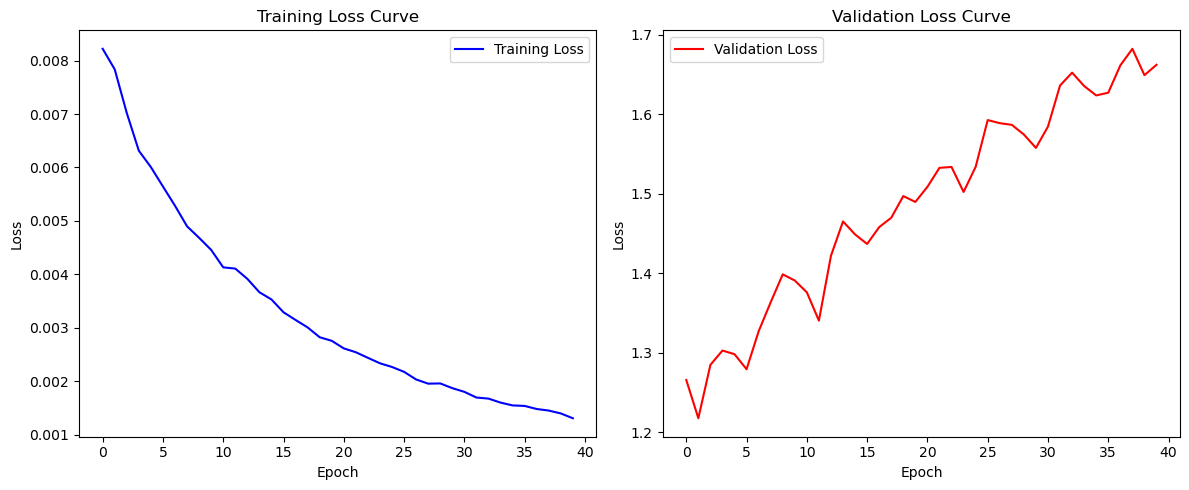

In [14]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title("Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# Feed Forward Fully Connected Model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from torch.utils.data import DataLoader, TensorDataset

class DarwinModel(LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the sequence dimension
        x = x.view(x.size(0), -1)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return torch.sigmoid(self.layer3(x))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # Call forward
        loss = nn.functional.binary_cross_entropy(y_hat.squeeze(), y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # Call forward
        loss = nn.functional.binary_cross_entropy(y_hat.squeeze(), y)
        self.log('val_loss', loss)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # Call forward
        loss = nn.functional.binary_cross_entropy(y_hat.squeeze(), y)
        self.log('test_loss', loss)
        return {'test_loss': loss}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

# Create the model
input_size = X_train_tensor.size(1) * X_train_tensor.size(2)  # product of dimensions except batch
hidden_size = 100  # Placeholder, can be optimized with Optuna
output_size = 1  # Since it's binary classification

model = DarwinModel(input_size, hidden_size, output_size)


In [10]:
# Define the PyTorch Lightning trainer
trainer = Trainer(max_epochs=50)

# Start training
trainer.fit(model, dl_train, dl_val)

# Optionally, run tests
trainer.test(dataloaders=dl_test)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | layer1 | Linear | 45.2 K
1 | layer2 | Linear | 10.1 K
2 | layer3 | Linear | 101   
3 | relu   | ReLU   | 0     
----------------------------------
55.4 K    Trainable params
0         Non-trainable params
55.4 K    Total params
0.222     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
C:\Users\rahmt\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at C:\Users\rahmt\OneDrive\Documents\DBMI\SPRING 2024\Deep Learning\Project\lightning_logs\version_1\checkpoints\epoch=49-step=200.ckpt
Loaded model weights from the checkpoint at C:\Users\rahmt\OneDrive\Documents\DBMI\SPRING 2024\Deep Learning\Project\lightning_logs\version_1\checkpoints\epoch=49-step=200.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            55.55555725097656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 55.55555725097656}]